In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima, AutoARIMA

In [2]:
NE_prices_avg = pd.read_csv('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\Niger_food_prices.csv')
NE_prices_avg.head()

,date,days,Maize - Retail,Rice (imported) - Retail,Sorghum - Retail,Millet - Retail,Beans (niebe) - Retail
0,1990-01-01,7305.0,58.25,201.666667,57.750000,61.00,NaN
1,1990-02-01,7336.0,58.25,201.666667,54.250000,63.40,NaN
2,1990-03-01,7364.0,58.25,201.666667,54.750000,65.20,NaN
3,1990-04-01,7395.0,58.25,202.333333,55.500000,69.60,NaN
4,1990-05-01,7425.0,58.25,202.333333,49.666667,63.25,NaN


In [3]:
NE_prices_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      379 non-null    object 
 1   days                      379 non-null    float64
 2   Maize - Retail            379 non-null    float64
 3   Rice (imported) - Retail  379 non-null    float64
 4   Sorghum - Retail          379 non-null    float64
 5   Millet - Retail           379 non-null    float64
 6   Beans (niebe) - Retail    210 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.9+ KB


In [4]:
NE_prices_avg['date'] = pd.to_datetime(NE_prices_avg['date'])
NE_prices_avg['date'].dtype

dtype('<M8[ns]')

In [5]:
NE_prices_avg.describe(include='all')

C:\Users\William\AppData\Local\Temp\ipykernel_20396\2483228287.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  NE_prices_avg.describe(include='all')


,date,days,Maize - Retail,Rice (imported) - Retail,Sorghum - Retail,Millet - Retail,Beans (niebe) - Retail
count,379,379.000000,379.000000,379.000000,379.000000,379.000000,210.000000
unique,379,NaN,NaN,NaN,NaN,NaN,NaN
top,1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
first,1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2021-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,13056.860158,168.070488,358.604192,157.184086,164.053058,242.776203
std,NaN,3334.503386,63.059627,100.458881,62.116393,65.912217,95.826828
min,NaN,7305.000000,58.250000,175.000000,45.666667,51.600000,93.583333
25%,NaN,10181.000000,124.285714,294.083333,111.500000,105.832317,176.108599


In [6]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y_pred - y)**2))
    

In [7]:
df = NE_prices_avg

df['year'] = pd.DatetimeIndex(NE_prices_avg['date']).year
df['month'] = pd.DatetimeIndex(NE_prices_avg['date']).month

df = pd.get_dummies(df, columns=['month'])

df.head()

,date,days,Maize - Retail,Rice (imported) - Retail,Sorghum - Retail,Millet - Retail,Beans (niebe) - Retail,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1990-01-01,7305.0,58.25,201.666667,57.750000,61.00,NaN,1990,1,0,0,0,0,0,0,0,0,0,0,0
1,1990-02-01,7336.0,58.25,201.666667,54.250000,63.40,NaN,1990,0,1,0,0,0,0,0,0,0,0,0,0
2,1990-03-01,7364.0,58.25,201.666667,54.750000,65.20,NaN,1990,0,0,1,0,0,0,0,0,0,0,0,0
3,1990-04-01,7395.0,58.25,202.333333,55.500000,69.60,NaN,1990,0,0,0,1,0,0,0,0,0,0,0,0
4,1990-05-01,7425.0,58.25,202.333333,49.666667,63.25,NaN,1990,0,0,0,0,1,0,0,0,0,0,0,0


In [8]:
months = [col for col in df if col.startswith('month')]
months

['month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [9]:
global_millet_price_change = pd.read_csv('E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-2-Data/global_millet_price_change.csv')
global_millet_price_change['date'] = pd.to_datetime(global_millet_price_change['date'])

global_millet_price_change.head()

,date,pct_change,undiff_change
0,1992-01-01,-0.723219,1.000000
1,1992-02-01,0.073370,1.073370
2,1992-03-01,0.048017,1.124910
3,1992-04-01,0.001899,1.127046
4,1992-05-01,-0.008822,1.117103


In [10]:
df = pd.merge(left=df, right=global_millet_price_change, how='left', on='date')

df['pct_change'].fillna(value=0, inplace=True)
df['undiff_change'].fillna(value=0, inplace=True)

df.head()

,date,days,Maize - Retail,Rice (imported) - Retail,Sorghum - Retail,Millet - Retail,Beans (niebe) - Retail,year,month_1,month_2,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,pct_change,undiff_change
0,1990-01-01,7305.0,58.25,201.666667,57.750000,61.00,NaN,1990,1,0,...,0,0,0,0,0,0,0,0,0.0,0.0
1,1990-02-01,7336.0,58.25,201.666667,54.250000,63.40,NaN,1990,0,1,...,0,0,0,0,0,0,0,0,0.0,0.0
2,1990-03-01,7364.0,58.25,201.666667,54.750000,65.20,NaN,1990,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
3,1990-04-01,7395.0,58.25,202.333333,55.500000,69.60,NaN,1990,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
4,1990-05-01,7425.0,58.25,202.333333,49.666667,63.25,NaN,1990,0,0,...,1,0,0,0,0,0,0,0,0.0,0.0


In [11]:
train = df[df['date'].dt.strftime('%Y') < '2018']
test = df[df['date'].dt.strftime('%Y') >= '2018']

In [12]:
X_train, X_test = pd.DataFrame(train['days']), pd.DataFrame(test['days'])
y_train, y_test = train['Millet - Retail'], test['Millet - Retail']

<AxesSubplot:>

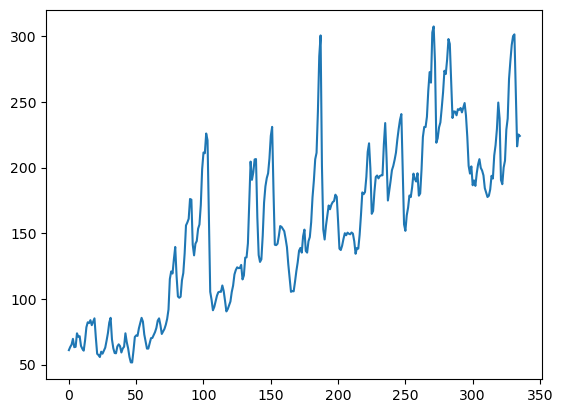

In [13]:
y_train.plot()

In [14]:
LR = LinearRegression()

LR.fit(X_train, y_train)

train_predict = LR.predict(X_train)
test_predict = LR.predict(X_test)

In [15]:
print('train rmse:', rmse(y_train, train_predict))
print('test rmse:', rmse(y_test, test_predict))
print('train mape:', mean_absolute_percentage_error(y_train, train_predict))
print('test mape:', mean_absolute_percentage_error(y_test, test_predict))

train rmse: 33.73973999996994
test rmse: 43.03445910490335
train mape: 0.17918389802648838
test mape: 0.1736614901312957


In [16]:
def plot_predict(X_train, X_test, y_train, y_test, train_predict, test_predict):
    plt.plot(X_train['days'], y_train, color='g', label='Train data')
    plt.plot(X_test['days'], y_test, color='r', label='Test data')
    plt.plot(X_train['days'], train_predict, color='b', label='Train prediction')
    plt.plot(X_test['days'], test_predict, color='k', label='Test prediction')
    plt.legend()
    return plt.show()

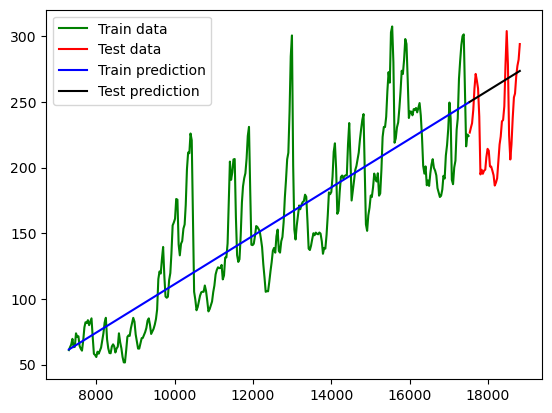

In [17]:
plot_predict(X_train, X_test, y_train, y_test, train_predict, test_predict)

In [18]:
included_features = ['days', 'year'] + months

X_train, X_test = pd.DataFrame(train[included_features]), pd.DataFrame(test[included_features])
y_train, y_test = train['Millet - Retail'], test['Millet - Retail']

In [19]:
LR = LinearRegression()

LR.fit(X_train, y_train)

train_predict = LR.predict(X_train)
test_predict = LR.predict(X_test)

In [20]:
print('train rmse:', rmse(y_train, train_predict))
print('test rmse:', rmse(y_test, test_predict))
print('train mape:', mean_absolute_percentage_error(y_train, train_predict))
print('test mape:', mean_absolute_percentage_error(y_test, test_predict))

train rmse: 28.487566324463685
test rmse: 35.81046077610647
train mape: 0.1594895872546858
test mape: 0.1418400553426637


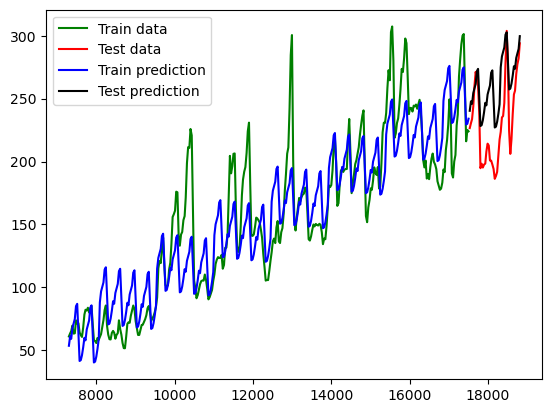

In [21]:
plot_predict(X_train, X_test, y_train, y_test, train_predict, test_predict)

In [22]:
df.columns

Index(['date', 'days', 'Maize - Retail', 'Rice (imported) - Retail',
       'Sorghum - Retail', 'Millet - Retail', 'Beans (niebe) - Retail', 'year',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'pct_change', 'undiff_change'],
      dtype='object')

In [23]:
included_features = ['days', 'year', 'pct_change', 'undiff_change'] + months

X_train, X_test = pd.DataFrame(train[included_features]), pd.DataFrame(test[included_features])
y_train, y_test = train['Millet - Retail'], test['Millet - Retail']

In [24]:
LR = LinearRegression()

LR.fit(X_train, y_train)

train_predict = LR.predict(X_train)
test_predict = LR.predict(X_test)

print('train rmse:', rmse(y_train, train_predict))
print('test rmse:', rmse(y_test, test_predict))
print('train mape:', mean_absolute_percentage_error(y_train, train_predict))
print('test mape:', mean_absolute_percentage_error(y_test, test_predict))

train rmse: 27.32684841207991
test rmse: 74.28719900706305
train mape: 0.15548417223754882
test mape: 0.31630613821128944


In [25]:
pipe = Pipeline([
    ('MinMax Scaling', MinMaxScaler()),
    ('Linear Regressor', LinearRegression())
])

In [26]:
pipe.fit(X_train, y_train)

train_predict = pipe.predict(X_train)
test_predict = pipe.predict(X_test)

print('train rmse:', rmse(y_train, train_predict))
print('test rmse:', rmse(y_test, test_predict))
print('train mape:', mean_absolute_percentage_error(y_train, train_predict))
print('test mape:', mean_absolute_percentage_error(y_test, test_predict))

train rmse: 27.32684841245939
test rmse: 74.28719900959783
train mape: 0.15548417224130195
test mape: 0.3163061382245541


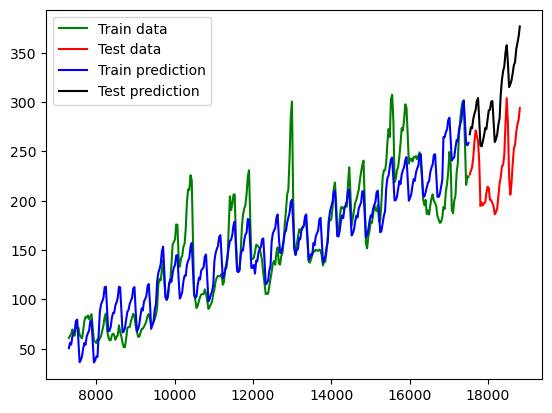

In [27]:
plot_predict(X_train, X_test, y_train, y_test, train_predict, test_predict)

**ARIMA**

In [28]:
train_arima = train[['Millet - Retail']]
test_arima = test[['Millet - Retail']]

In [29]:
train_arima.head()

,Millet - Retail
0,61.00
1,63.40
2,65.20
3,69.60
4,63.25


Check for stationarity and determine (d)

In [30]:
result = adfuller(train_arima)

print('ADF statistic:', result[0])
print('p-value:', result[1])

ADF statistic: -1.6995540475060136
p-value: 0.43134225964689465


Clearly the series is not stationary

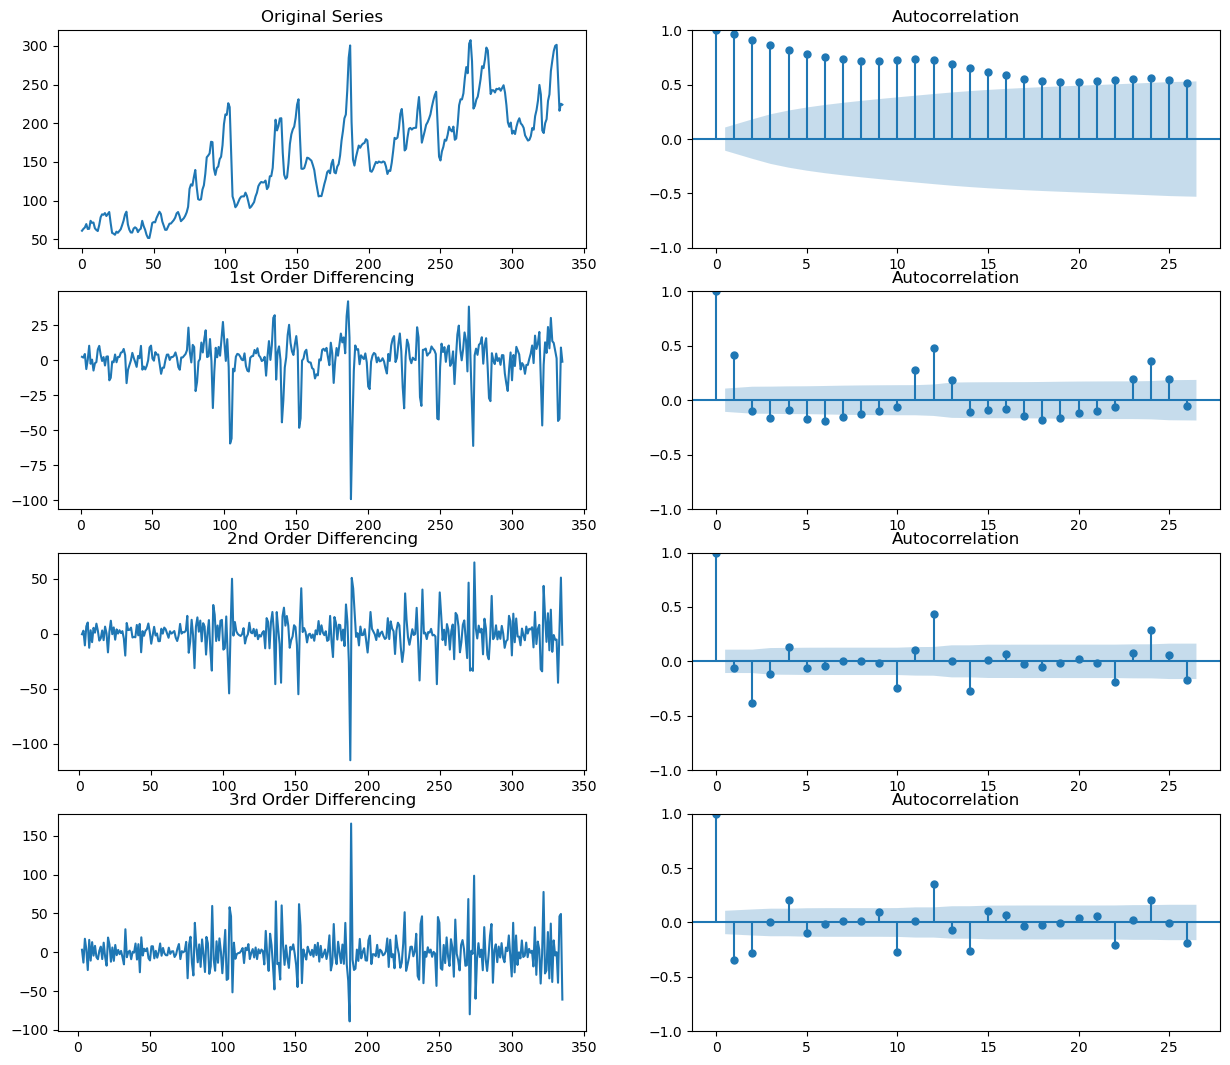

In [31]:
fig, axes = plt.subplots(4, 2)
fig.set_size_inches(15, 13)

# Original Series
axes[0, 0].plot(train_arima); axes[0, 0].set_title('Original Series')
plot_acf(train_arima, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_arima.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_arima.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_arima.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_arima.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(train_arima.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(train_arima.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

In [32]:
result = adfuller(train_arima.diff().dropna())

print('ADF statistic:', result[0])
print('p-value:', result[1])

ADF statistic: -4.939391826242989
p-value: 2.9212907710117754e-05


After one difference, the series reaches stationarity, and further diffrences clearly over-difference instead. I will set (d) = 1

Next, the AR term (p), will be found using the partial autocorrelation plot of the DIFFERENCED series, as this trick only works with a stationary series

c:\Users\William\anaconda3\envs\Springboard_Capstone_2\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


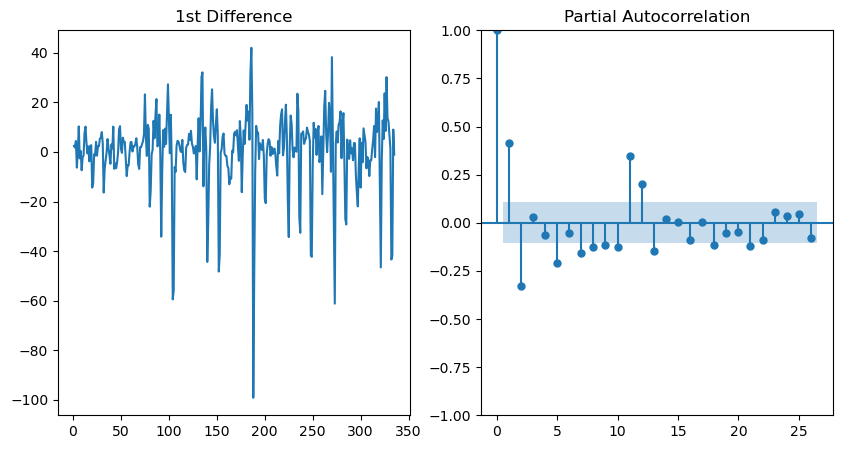

In [33]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axes[0].plot(train_arima.diff()); axes[0].set_title('1st Difference')
axes[1].set(ylim=(0))
plot_pacf(train_arima.diff().dropna(), ax=axes[1])

plt.show()

I will set the (p) value as 2

In order to find the MA term (q) the same way, but with the autocorrelation instead of the partial autocorrelation

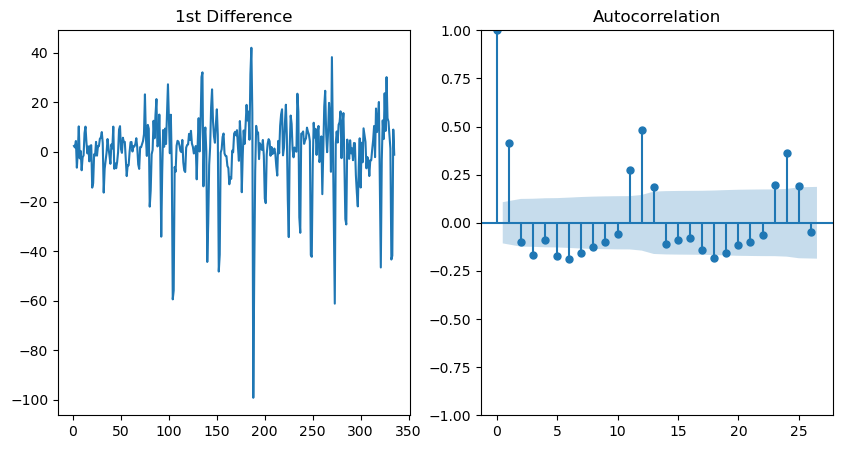

In [34]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axes[0].plot(train_arima.diff()); axes[0].set_title('1st Difference')
axes[1].set(ylim=(0))
plot_acf(train_arima.diff().dropna(), ax=axes[1])

plt.show()

I will set the (q) term to be 1. Next, I will build the ARIMA model and check its statistics

In [35]:
# 2, 1, 1 ARIMA model
arima_model = ARIMA(train_arima, order=(2,1,1))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        Millet - Retail   No. Observations:                  336
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1334.575
Date:                Fri, 31 Mar 2023   AIC                           2677.151
Time:                        14:50:16   BIC                           2692.407
Sample:                             0   HQIC                          2683.233
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4311      0.158      2.735      0.006       0.122       0.740
ar.L2         -0.2768      0.079     -3.487      0.000      -0.432      -0.121
ma.L1          0.1292      0.171      0.753      0.4

Now to plot the residuals and ensure there is no pattern

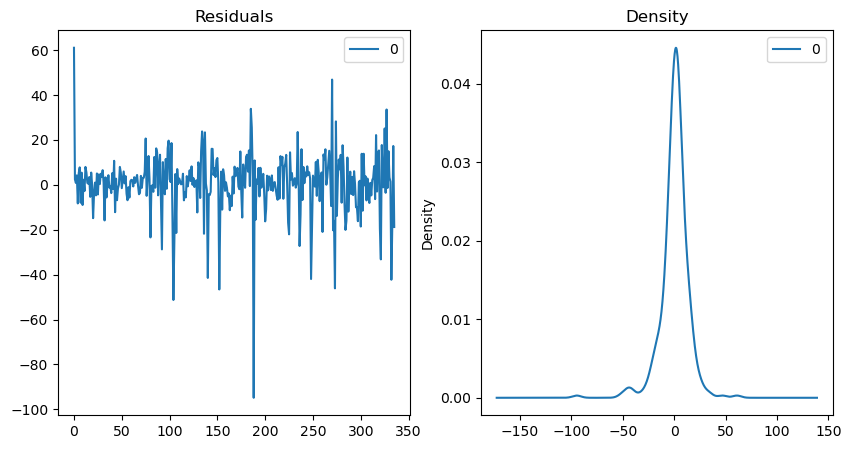

In [36]:
residuals = pd.DataFrame(arima_model_fit.resid)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)

residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

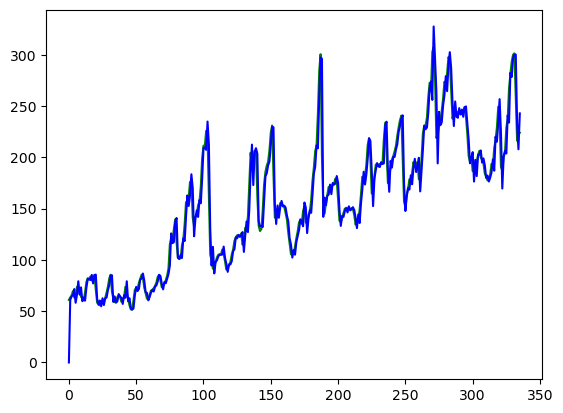

In [37]:
train_predict = arima_model_fit.predict()
plt.plot(train_arima, color='g', label='Train data')
plt.plot(train_predict, color='b', label='Train prediction')
plt.show()

In [38]:
test_arima[-1:].index

Int64Index([378], dtype='int64')

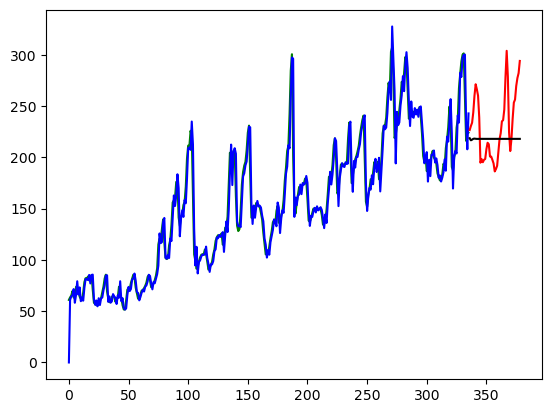

In [39]:
test_predict = arima_model_fit.forecast(steps=379 - len(train_arima))

plt.plot(train_arima, color='g', label='Train data')
plt.plot(train_predict, color='b', label='Train prediction')
plt.plot(test_arima, color='r', label='Test data')
plt.plot(test_predict, color='k', label='Test prediction')
plt.show()

In [40]:
# 2, 1, 30? ARIMA model
arima_model = ARIMA(train_arima, order=(2,1,30))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

c:\Users\William\anaconda3\envs\Springboard_Capstone_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\William\anaconda3\envs\Springboard_Capstone_2\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:        Millet - Retail   No. Observations:                  336
Model:                ARIMA(2, 1, 30)   Log Likelihood               -1277.255
Date:                Fri, 31 Mar 2023   AIC                           2620.510
Time:                        14:50:33   BIC                           2746.376
Sample:                             0   HQIC                          2670.689
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4526      0.179      2.528      0.011       0.102       0.803
ar.L2          0.0005      0.203      0.002      0.998      -0.398       0.399
ma.L1          0.0379      0.179      0.211      0.8

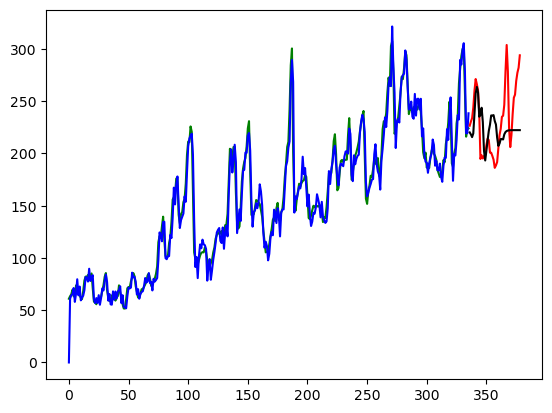

In [41]:
train_predict = arima_model_fit.predict()
test_predict = arima_model_fit.forecast(steps=379 - len(train_arima))

plt.plot(train_arima, color='g', label='Train data')
plt.plot(train_predict, color='b', label='Train prediction')
plt.plot(test_arima, color='r', label='Test data')
plt.plot(test_predict, color='k', label='Test prediction')
plt.show()

AutoArima test

In [42]:
sarima = auto_arima(train_arima, start_P=1, start_Q=1, test='adf', 
                    max_P=3, max_Q=3, seasonal=True, m=12, trace=True, d=1, D=1)

sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2668.848, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2583.961, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2630.190, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2504.234, Time=0.35 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2447.838, Time=0.73 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=2442.798, Time=2.21 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=2443.528, Time=1.19 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=2442.571, Time=3.61 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=2444.612, Time=1.82 sec
 ARIMA(1,1,0)(3,1,3)[12]             : AIC=2436.198, Time=5.18 sec
 ARIMA(1,1,0)(2,1,3)[12]             : AIC=2434.198, Time=3.50 sec
 ARIMA(1,1,0)(1,1,3)[12]             : AIC=2452.876, Time=2.01 sec
 ARIMA(1,1,0)(1,1,2)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  336
Model:             SARIMAX(2, 1, 0)x(2, 1, [1, 2, 3], 12)   Log Likelihood               -1206.502
Date:                                    Fri, 31 Mar 2023   AIC                           2429.004
Time:                                            14:52:01   BIC                           2459.225
Sample:                                                 0   HQIC                          2441.068
                                                    - 336                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3025      0.044      6.803      0.000       0.215       0.390
ar.L2         -0.1508      0.052     -2.903      0.004      -0.253      -0.049
ar.S.L12      -0.0951      0.085     -1.124      0.261      -0.261       0.071
ar.S.L24      -0.8053      0.083     -9.725      0.000      -0.968      -0.643
ma.S.L12      -0.7770      0.106     -7.354      0.000      -0.984      -0.570
ma.S.L24       0.5666      0.148      3.828      0.000       0.277       0.857
ma.S.L36      -0.4885      0.100     -4.890      0.000      -0.684      -0.293
sigma2        96.4782      4.930     19.570      0.000      86.816     106.141
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               881.51
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                            -1.33
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
sarima.params

<bound method ARIMA.params of ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 1, 3, 12),
      suppress_warnings=True, with_intercept=False)>

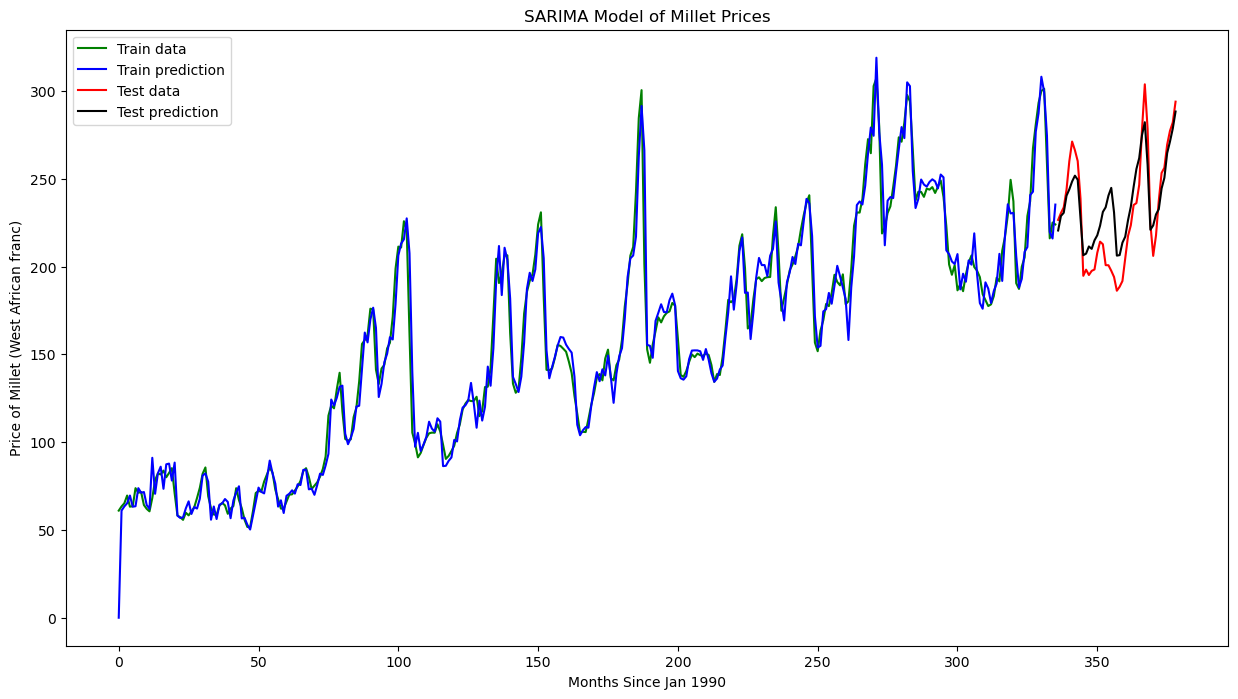

In [44]:
train_predict = sarima.predict_in_sample()
test_predict = sarima.predict(n_periods=len(test_arima))

plt.rcParams["figure.figsize"] = (15,8)
plt.plot(train_arima, color='g', label='Train data')
plt.plot(train_predict, color='b', label='Train prediction')
plt.plot(test_arima, color='r', label='Test data')
plt.plot(test_predict, color='k', label='Test prediction')
plt.title('SARIMA Model of Millet Prices')
plt.xlabel('Months Since Jan 1990')
plt.ylabel('Price of Millet (West African franc)')
plt.legend()
plt.show()

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [45]:
print('train rmse:', mean_squared_error(train_arima, train_predict, squared=False))
print('test rmse:', mean_squared_error(test_arima, test_predict, squared=False))
print('train mape:', mean_absolute_percentage_error(train_arima, train_predict))
print('test mape:', mean_absolute_percentage_error(test_arima, test_predict))

train rmse: 10.396707110843803
test rmse: 17.26764411569638
train mape: 0.04916431539209533
test mape: 0.0643521367912018


In [46]:
tscv = TimeSeriesSplit()

print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


0.34056283193488224
1.45358197401182
0.21625658489320548
0.1562560057071696
0.32551937421769533


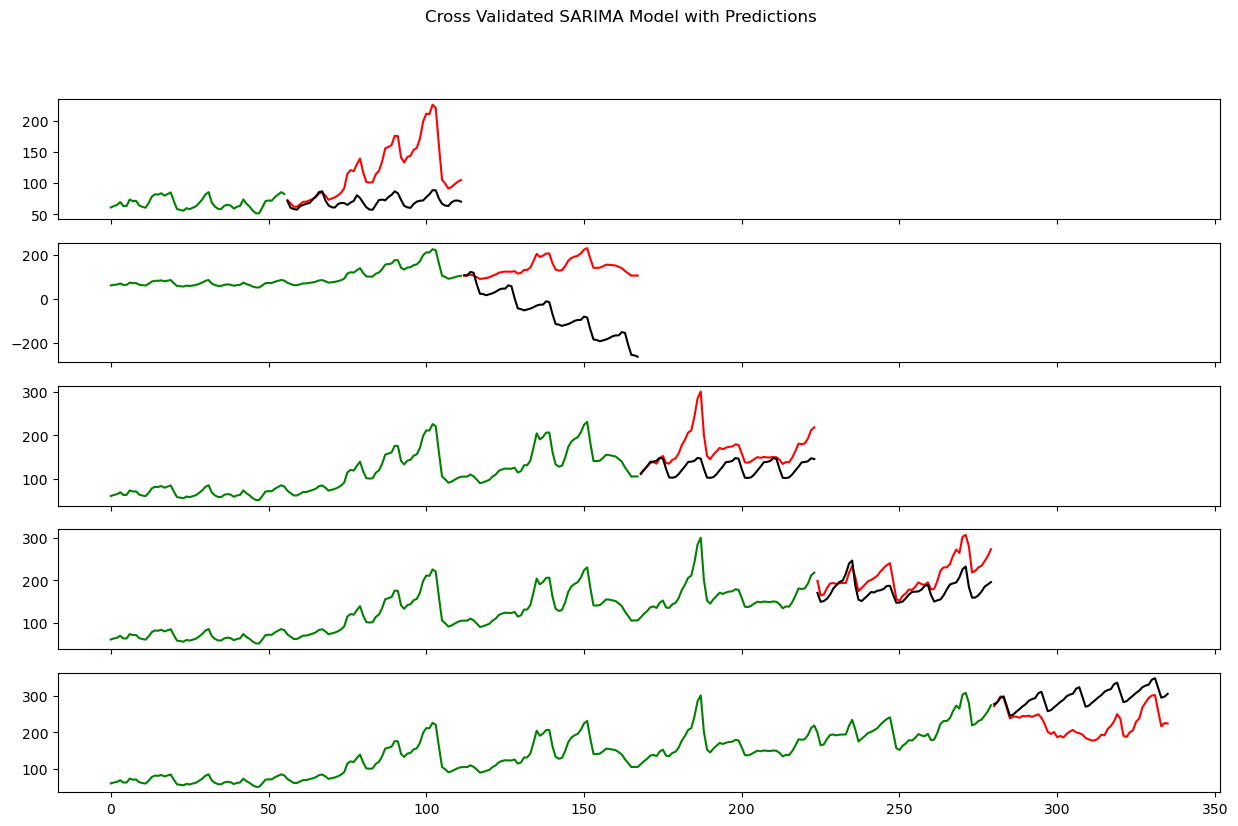

In [47]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(15, 9)
fig.suptitle('Cross Validated SARIMA Model with Predictions')

for i, (train_index, test_index) in enumerate(tscv.split(train_arima)):

    # Creating the new Train and Test sets
    cv_train, cv_test = train_arima.iloc[train_index], train_arima.iloc[test_index]

    # Uning auto_arima to find the best model for this fold
    sarima = auto_arima(cv_train, start_P=1, start_Q=1, test='adf', 
                    max_P=3, max_Q=3, seasonal=True, m=12, trace=False, d=1, D=1)

    # Getting predictions for the test fold
    predictions = sarima.predict(n_periods=len(cv_test))

    # Print r2 score 
    print(mean_absolute_percentage_error(cv_test, predictions))

    
    ax[i].plot(cv_train, color='g', label='Train data')
    ax[i].plot(cv_test, color='r', label='Test data')
    ax[i].plot(predictions, color='k', label='Test prediction')
    
